# Fitting a BNN to (synthetic) hpolib benchmark functions

In this notebook we fit a bayesian neural network to a collection of synthetic function taken from the hpolib library. TODO INSERT LINK TO HPOLIB

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Epoch 1/1
   44/13000 [..............................] - ETA: 659s - loss: 460.9333 - mean_squared_error: 24.4893 - mean_absolute_error: 3.7907

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102248). Check your callbacks.
  % delta_t_median)


13000/13000 [==============================] - 39s - loss: 37.7311 - mean_squared_error: 26.6311 - mean_absolute_error: 3.6591    
Learning rate ended at -0.015592227689921856
Epoch 1/1
13000/13000 [==============================] - 36s - loss: 82.9216 - mean_squared_error: 25.7490 - mean_absolute_error: 3.6380    
Learning rate ended at 0.016329066827893257
Epoch 1/1
13000/13000 [==============================] - 38s - loss: 247.0236 - mean_squared_error: 23.9166 - mean_absolute_error: 3.6079    
Learning rate ended at 0.009158286266028881
Epoch 1/1
13000/13000 [==============================] - 39s - loss: 128.5455 - mean_squared_error: 21.4235 - mean_absolute_error: 3.3471    
Learning rate ended at -0.013301867060363293
Epoch 1/1
13000/13000 [==============================] - 38s - loss: 98.3120 - mean_squared_error: 23.0020 - mean_absolute_error: 3.4542    
Learning rate ended at -0.016623342409729958
Epoch 1/1
13000/13000 [==============================] - 37s - loss: 365.5709 - 

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104387). Check your callbacks.
  % delta_t_median)


13000/13000 [==============================] - 38s - loss: 427.9658 - mean_squared_error: 22.8597 - mean_absolute_error: 3.7090    
Learning rate ended at -0.0030318666249513626


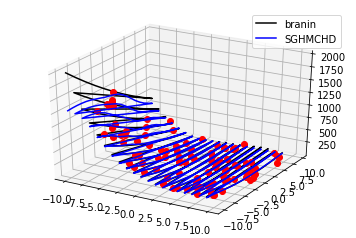

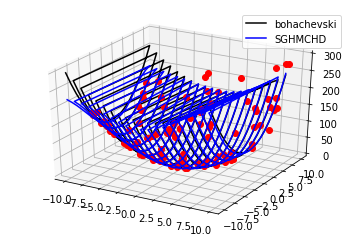

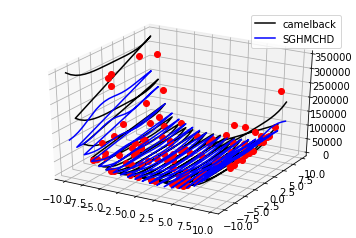

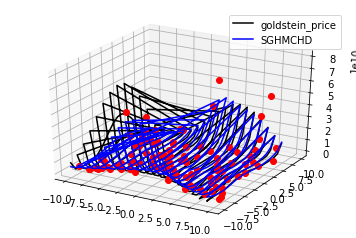

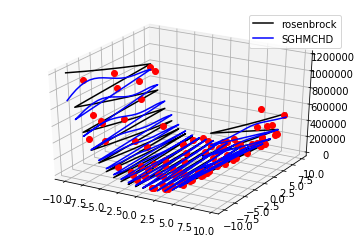

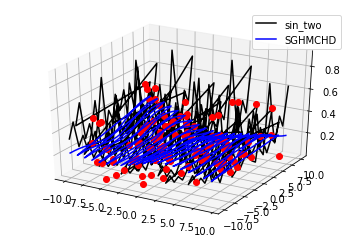

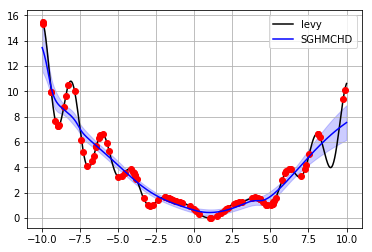

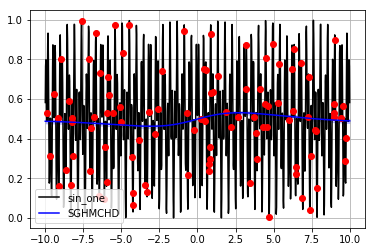

In [20]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join("..", "..", "..")))
import numpy as np
from itertools import islice
import matplotlib.pyplot as plt
import seaborn as sns
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from pysgmcmc.optimizers.sghmchd import SGHMC
from pysgmcmc.optimizers.sghmchd import SGHMCHD
from pysgmcmc.models.bayesian_neural_network import (
    BayesianNeuralNetwork
)
from itertools import product

from pysgmcmc.models.objective_functions import (
    branin, bohachevski, camelback, goldstein_price, rosenbrock,
    sin_two, levy, sin_one
)

def init_random_uniform(lower, upper, n_points, rng=None):
    if rng is None:
        rng = np.random.RandomState(np.random.randint(0, 10000))

    n_dims = lower.shape[0]

    return np.array(
        [rng.uniform(lower, upper, n_dims) for _ in range(n_points)]
    )


def plot_1d(train_data, test_data, prediction_mean, prediction_std, function_label, optimizer_label):
    x_train, y_train = train_data
    x_test, y_test = test_data
    
    # XXX: Make plot function generic to allow plotting 2d functions properly

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.grid()

    ax.plot(x_test[:, 0], y_test, label=function_label, color="black")
    ax.plot(x_train[:, 0], y_train, "ro")

    ax.plot(x_test[:, 0], prediction_mean, label=optimizer_label, color="blue")
    ax.fill_between(x_test[:, 0], prediction_mean + prediction_std, prediction_mean - prediction_std, alpha=0.2, color="blue")

    ax.legend()

    
def plot_2d(train_data, test_data, prediction_mean, prediction_std, function_label, optimizer_label):
    x_train, y_train = train_data
    x_test, y_test = test_data
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.grid()

    
    ax.plot(x_test[:, 0], x_test[:, 1], y_test, label=function_label, color="black")
    ax.plot(x_train[:, 0], x_train[:, 1], y_train, "ro")
    
    ax.plot(x_test[:, 0], x_test[:, 1], prediction_mean, label=optimizer_label, color="blue")
    ax.legend()


def fit_bnn(objective_function_name, train_data, test_data, optimizer, optimizer_kwargs):
    from keras import backend as K

    x_train, y_train = train_data
    x_test, y_test = test_data
    
    _, num_dims = x_train.shape
    
    model = BayesianNeuralNetwork(
        burn_in_steps=3000,
        optimizer=optimizer, **optimizer_kwargs
    )
    model.train(x_train, y_train)
    
    lr = K.get_value(model.optimizer.lr)

    prediction_mean, prediction_variance = model.predict(x_test)

    prediction_std = np.sqrt(prediction_variance)
    
    if num_dims == 2:
        plot_2d(
            train_data=train_data, 
            test_data=test_data, 
            prediction_mean=prediction_mean,
            prediction_std=prediction_std,
            function_label=objective_function_name,
            optimizer_label=optimizer.__name__
        )
    elif num_dims == 1:
        plot_1d(
            train_data=train_data,
            test_data=test_data,
            prediction_mean=prediction_mean,
            prediction_std=prediction_std,
            function_label=objective_function_name,
            optimizer_label=optimizer.__name__
        )
    else:
        raise ValueError("Invalid number of dimensions!")
    
    return lr

OBJECTIVE_FUNCTIONS = (
    (branin, 2, 100),
    (bohachevski, 2, 100),
    (camelback, 2, 100), 
    (goldstein_price, 2, 100),
    (rosenbrock, 2, 100),
    (sin_two, 2, 100),
    (levy, 1, 100),
    (sin_one, 1, 100),
)


for objective_function, num_dims, num_points in OBJECTIVE_FUNCTIONS:
    lower = np.ones(num_dims) * -10
    upper = np.ones(num_dims) * 10

    x_train = init_random_uniform(lower=lower, upper=upper, n_points=num_points)
    y_train = np.asarray([objective_function(x) for x in x_train])
    
    if num_dims == 1:
        x_test = np.linspace(-10, 10, 1000)[:, None]
    elif num_dims == 2:
        x_test = np.asarray(list(product(range(-10, 10), range(-10, 10))))
    
    y_test = np.asarray([objective_function(x) for x in x_test])
    
    final_lr = fit_bnn(objective_function_name=objective_function.__name__,
            train_data=(x_train, y_train), 
            test_data=(x_test, y_test),
            optimizer=SGHMCHD, optimizer_kwargs={"learning_rate": 1e-7})
    print("Learning rate ended at {}".format(final_lr))
